# **社群媒體分析_期中專案**

* **組員：M094810008 黃子源、M094030040 孫亦農、M104020058 黃弘瑋、M094111006 呂奕憲**

* **分析主題：罷免陳柏惟事件之社群討論_以PTT與DCARD為例**

* **資料來源：PTT - 中山文字分析平台  , DCARD - DCARD_API爬蟲**

* **資料期間：2021/03/05 ~ 2021/10/31**

## **1.載入套件**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.dates as mdate
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
from snownlp import SnowNLP
import seaborn as sns

## **2.資料前處理**

## 載入資料

In [468]:
MetaData_gossip = pd.read_csv('Data/bowei_gossip_articleMetaData.csv')
Reviews_gossip = pd.read_csv('Data/bowei_gossip２_articleReviews.csv')
MetaData_hatepolitic=pd.read_csv('Data/bowei_HatePolitics_articleMetaData.csv')
Reviews_hatepolitic = pd.read_csv('Data/bowei_HatePolitics_articleReviews.csv')
Dcard_content_data = pd.read_csv("Data/dcard_content_data.csv",encoding = "utf-8-sig")
Dcard_reply_data = pd.read_csv('Data/dcard_reply_data.csv',encoding = "utf-8-sig")

## 篩選資料期間

In [469]:
Dcard_content_data['date'] = pd.to_datetime(Dcard_content_data['createdAt']).dt.year*10000 + pd.to_datetime(Dcard_content_data['createdAt']).dt.month*100+pd.to_datetime(Dcard_content_data['createdAt']).dt.day
mask1 = Dcard_content_data['date']>=20210305
mask2 = Dcard_content_data['date']<20211101
Dcard_content_data = Dcard_content_data[mask1&mask2]

In [470]:
Dcard_reply_data['date'] = pd.to_datetime(Dcard_reply_data['createdAt']).dt.year*10000 + pd.to_datetime(Dcard_reply_data['createdAt']).dt.month*100+pd.to_datetime(Dcard_reply_data['createdAt']).dt.day
mask1 = Dcard_reply_data['date']>=20210305
mask2 = Dcard_reply_data['date']<20211101
Dcard_reply_data = Dcard_reply_data[mask1&mask2]

## 再次篩選標題具有關鍵字之文章

關鍵字：['罷免','伯惟','柏惟','柏維','刪Q','基進','選罷法','報復性','寬恆','顏家','惡罷','惡意罷免','三Q','3Q']

In [471]:
keywords = ['罷免','伯惟','柏惟','柏維','刪Q','基進','選罷法','報復性','寬恆','顏家','惡罷','惡意罷免','三Q','3Q']
toMatch = '|'.join(keywords)

In [472]:
MetaData_gossip = MetaData_gossip.loc[MetaData_gossip['artTitle'].str.contains(toMatch), :]
MetaData_gossip.reset_index(inplace=True, drop=True) 
MetaData_hatepolitic = MetaData_hatepolitic.loc[MetaData_hatepolitic['artTitle'].str.contains(toMatch), :]
MetaData_hatepolitic.reset_index(inplace=True, drop=True) 
Dcard_content_data.loc[Dcard_content_data['title'].str.contains(toMatch), :]
print("PTT八卦版總共有 ",MetaData_gossip.shape[0],"篇貼文""\nPTT政黑板總共有",MetaData_hatepolitic.shape[0],"篇貼文","\nDcard時事版總共有",Dcard_content_data.shape[0],"篇貼文")

PTT八卦版總共有  3461 篇貼文
PTT政黑板總共有 2935 篇貼文 
Dcard時事版總共有 385 篇貼文


In [473]:
Reviews_gossip = MetaData_gossip.iloc[:,0:-1].merge(Reviews_gossip.loc[:,["artUrl",'cmtPoster',"cmtContent"]], how = "left", on = 'artUrl')
Reviews_hatepolitic = MetaData_hatepolitic.iloc[:,0:-1].merge(Reviews_hatepolitic.loc[:,["artUrl",'cmtPoster',"cmtContent"]], how = "left", on = 'artUrl')
print("PTT八卦版總共有 ",Reviews_gossip.shape[0],"則留言" ,"\nPTT政黑版總共有",Reviews_hatepolitic.shape[0],"則留言","\nDcard時事版總共有",Dcard_reply_data.shape[0],"則留言")

PTT八卦版總共有  282193 則留言 
PTT政黑版總共有 97559 則留言 
Dcard時事版總共有 6431 則留言


## 合併資料

In [474]:
MetaData = pd.concat([MetaData_gossip,MetaData_hatepolitic],axis=0).reset_index() 
Reviews= pd.concat([Reviews_gossip,Reviews_hatepolitic],axis=0).reset_index() 

In [475]:
Reviews.dropna(subset = ["cmtContent"], inplace=True)
Dcard_reply_data.dropna(subset = ["content"], inplace=True)
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(完整內容|新聞|新聞網址|新聞來源|媒體來源|記者署名|網址來源|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '',str(x)))
Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', str(x)))
Dcard_content_data['content'] = Dcard_content_data.content.apply(lambda x: re.sub('(http|https)://.*', '', str(x)))
Dcard_content_data['content'] = Dcard_content_data.content.apply(lambda x:re.sub('[^\u4e00-\u9fa5]+', '', str(x)))
Dcard_reply_data['content'] = Dcard_reply_data.content.apply(lambda x: re.sub('[^\u4e00-\u9fa5]+', '', str(x)))
Dcard_reply_data.rename(columns={"postId": "id"},inplace=True)

## **3.透過N-gram幫助建立字典**

## 設定結巴斷詞系統

In [476]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

## bigram

In [477]:
# 設定 bigram 斷詞 function
def bigram_getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    seg_list = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list)]
    return seg_list

In [478]:
bowei_bigram_Meta = MetaData.copy()
bowei_bigram_Meta["word"] = bowei_bigram_Meta.sentence.apply(bigram_getToken)
bowei_bigram_Meta = bowei_bigram_Meta.explode('word')
bowei_bigram_Meta_count = bowei_bigram_Meta.groupby(["word"],as_index=False).size()
wb_filter = list(bowei_bigram_Meta_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
bowei_bigram_Meta_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

Building prefix dict from C:\Users\Roger\Desktop\研究所\碩二上\社群媒體分析\期中專案\dict\dict.txt.big ...
Loading model from cache C:\Users\Roger\AppData\Local\Temp\jieba.ub71048b8c07f5daab26a6e4a18fdb850.cache
Loading model cost 1.159 seconds.
Prefix dict has been built successfully.


,word,size
56421,台灣 基進,1158
150126,柏惟 罷免,1056
194890,立委 柏惟,695
207895,罷免 投票,540
74399,基進 立委,450
59903,同意 罷免,438
214094,肇事 逃逸,420
207818,罷免 成功,420
208257,罷免 柏惟,375
209531,罷免 門檻,373


In [480]:
bowei_bigram_Reviews = Reviews.copy()
bowei_bigram_Reviews["word"] = bowei_bigram_Reviews.cmtContent.apply(bigram_getToken)
bowei_bigram_Reviews = bowei_bigram_Reviews.explode('word')
bowei_bigram_Reviews.head(3)
bowei_bigram_Reviews_count = bowei_bigram_Reviews.groupby(["word"],as_index=False).size()
wb_filter = list(bowei_bigram_Reviews_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
bowei_bigram_Reviews_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
26068,中共 同路人,1319
402802,肇事 逃逸,1038
109402,台灣 價值,764
390970,罷免 成功,652
241349,支持 罷免,429
246587,政治 人物,402
110342,台灣 民主,374
120889,哈哈哈 哈哈哈,373
454495,賭博 電玩,372
88063,勇於 承擔,335


In [481]:
bowei_bigram_dcard_content = Dcard_content_data.copy()
bowei_bigram_dcard_content["word"] = bowei_bigram_dcard_content.content.apply(bigram_getToken)
bowei_bigram_dcard_content = bowei_bigram_dcard_content.explode('word')
bowei_bigram_dcard_content_count = bowei_bigram_dcard_content.groupby(["word"],as_index=False).size()
wb_filter = list(bowei_bigram_dcard_content_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
bowei_bigram_dcard_content_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
4780,台灣 基進,79
12902,柏惟 罷免,76
18873,肇事 逃逸,71
18274,罷免 柏惟,43
16952,立委 柏惟,43
18228,罷免 投票,42
6381,基進 立委,35
5125,同意 罷免,30
11194,政治 人物,29
6815,大麻 合法化,26


In [482]:
bowei_bigram_dcard_reply = Dcard_reply_data.copy()
bowei_bigram_dcard_reply["word"] = bowei_bigram_dcard_reply.content.apply(bigram_getToken)
bowei_bigram_dcard_reply = bowei_bigram_dcard_reply.explode('word')
bowei_bigram_dcard_reply_count = bowei_bigram_dcard_reply.groupby(["word"],as_index=False).size()
wb_filter = list(bowei_bigram_dcard_reply_count["word"].apply(lambda x: True if not re.search("[0-9a-zA-Z]",x) else False))
bowei_bigram_dcard_reply_count[wb_filter].sort_values(by=['size'], ascending=False).head(10)

,word,size
28197,肇事 逃逸,94
16384,支持 柏惟,94
27332,罷免 柏惟,69
19124,柏惟 支持,61
1736,中國 疫苗,61
16428,支持 罷免,57
27448,罷免 總統,45
1568,中共 同路人,41
27268,罷免 成功,41
10139,報復性 罷免,34


從上面 bigram 結果中，我們發現"台灣 價值","中共 同路人","肇事 逃逸"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。
我們將詞彙整理存在 dict 文件夾中的 bowei_dict.txt 中。

## **4.斷詞**

In [483]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/bowei_dict.txt')
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
w=['高雄','不用','當初','嘻嘻','反正','一堆','只能','明明','有沒有','只會','整天','一點','幹嘛','這是','有人','地方','還在','台中','投票','選民']
for i in w:
    stopWords.append(i)

Building prefix dict from C:\Users\Roger\Desktop\研究所\碩二上\社群媒體分析\期中專案\dict\dict.txt.big ...
Loading model from cache C:\Users\Roger\AppData\Local\Temp\jieba.ub71048b8c07f5daab26a6e4a18fdb850.cache
Loading model cost 1.207 seconds.
Prefix dict has been built successfully.


In [484]:
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w) > 1] 
    return seg_list

In [485]:
MetaData['word'] = MetaData.sentence.apply(getToken)
MetaData_token = MetaData.explode('word')

In [486]:
Reviews['word'] = Reviews.cmtContent.apply(getToken)
Reviews_token = Reviews.explode('word') 

In [487]:
Dcard_content_data['word'] = Dcard_content_data.content.apply(getToken)
Dcard_content_token = Dcard_content_data.explode('word')

In [488]:
Dcard_reply_data['word'] = Dcard_reply_data.content.apply(getToken)
Dcard_reply_token = Dcard_reply_data.explode('word')

In [489]:
Ptt_data = pd.concat([MetaData_token.loc[:,["artDate","artUrl",'artCat',"word"]],Reviews_token.loc[:,["artDate","artUrl",'artCat',"word"]]],axis=0)
Ptt_data['artDate'] = pd.to_datetime(Ptt_data['artDate'], format="%Y/%m/%d")

In [490]:
Dcard_data = pd.concat([Dcard_content_token.loc[:,["date","id","word"]],Dcard_reply_token.loc[:,["date","id","word"]]],axis=0)
Dcard_data['date'] = pd.to_datetime(Dcard_data['date'],format='%Y%m%d')

## 文章數與文字雲

Text(0, 0.5, 'count')

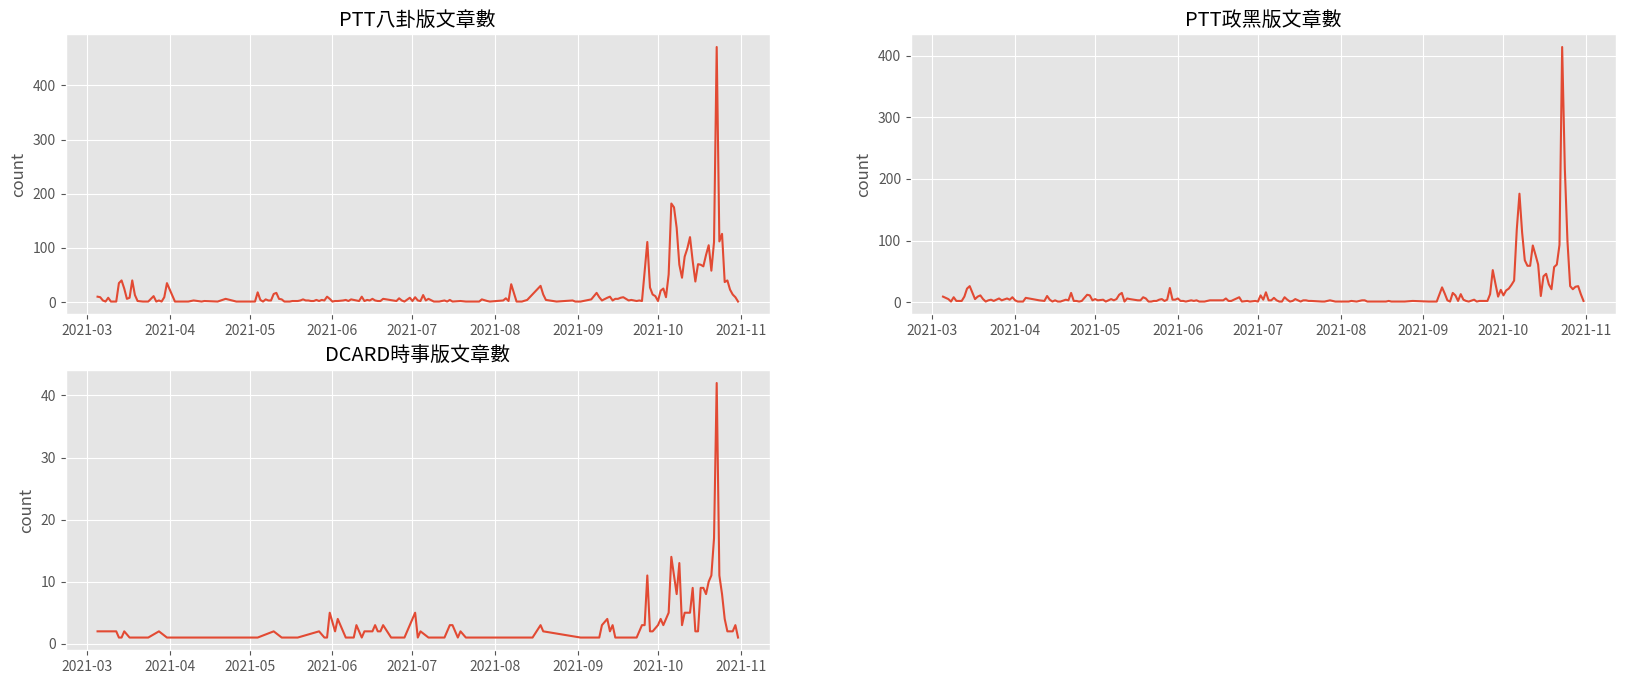

In [491]:
MetaData_gossip['artDate'] = pd.to_datetime(MetaData_gossip['artDate'],format='%Y/%m/%d')
MetaData_hatepolitic['artDate'] = pd.to_datetime(MetaData_hatepolitic['artDate'],format='%Y/%m/%d')
PTT_gossip_datecount = pd.DataFrame(MetaData_gossip.groupby('artDate').size(),columns = ['count'])
PTT_hatepolitic_datecount = pd.DataFrame(MetaData_hatepolitic.groupby('artDate').size(),columns = ['count'])


plt.figure(figsize=(20,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號

a = plt.subplot(221)
plt.plot(PTT_gossip_datecount.index,PTT_gossip_datecount['count'].tolist())
plt.title('PTT八卦版文章數')
plt.ylabel('count')
b = plt.subplot(222)
plt.plot(PTT_hatepolitic_datecount.index,PTT_hatepolitic_datecount['count'].tolist())
plt.title('PTT政黑版文章數')
plt.ylabel('count')
c = plt.subplot(223)
plt.plot(Dcard_datecount.index,Dcard_datecount['count'].tolist())
plt.title('DCARD時事版文章數')
plt.ylabel('count')

In [492]:
#計算詞頻
Ptt_word_count = Ptt_data.groupby(['artCat','word'],as_index=False).size()
Ptt_word_count.sort_values(by=['size'], ascending=False,inplace=True) 
Ptt_word_count = Ptt_word_count[Ptt_word_count['size']>3]
Ptt_word_count = pd.DataFrame(Ptt_word_count)
Ptt_word_count.head(5)

,artCat,word,size
65296,Gossiping,罷免,17866
138175,HatePolitics,罷免,12214
22285,Gossiping,塔綠班,11420
59581,Gossiping,真的,10146
61428,Gossiping,立委,8862


In [131]:
Dcard_word_count = Dcard_data.groupby(['word'],as_index=False).size()
Dcard_word_count.sort_values(by=['size'], ascending=False,inplace=True) 
Dcard_word_count = Dcard_word_count[Dcard_word_count['size']>3]
Dcard_word_count["artCat"]="Dcard"
Dcard_word_count = pd.DataFrame(Dcard_word_count)
Dcard_word_count.head(5)

,word,size,artCat
13060,罷免,2070,Dcard
17044,陳柏惟,1394,Dcard
12333,立委,827,Dcard
10076,民進黨,787,Dcard
8250,支持,677,Dcard


In [493]:
word_count = pd.concat([Ptt_word_count,Dcard_word_count])

In [494]:
def Wc_dict(df, cat, countB, countS):
    wc_df = (df.query('artCat == @cat') # 篩選日期
             .query('size < @countB')# 篩選最大數量
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict

### 八卦版文字雲

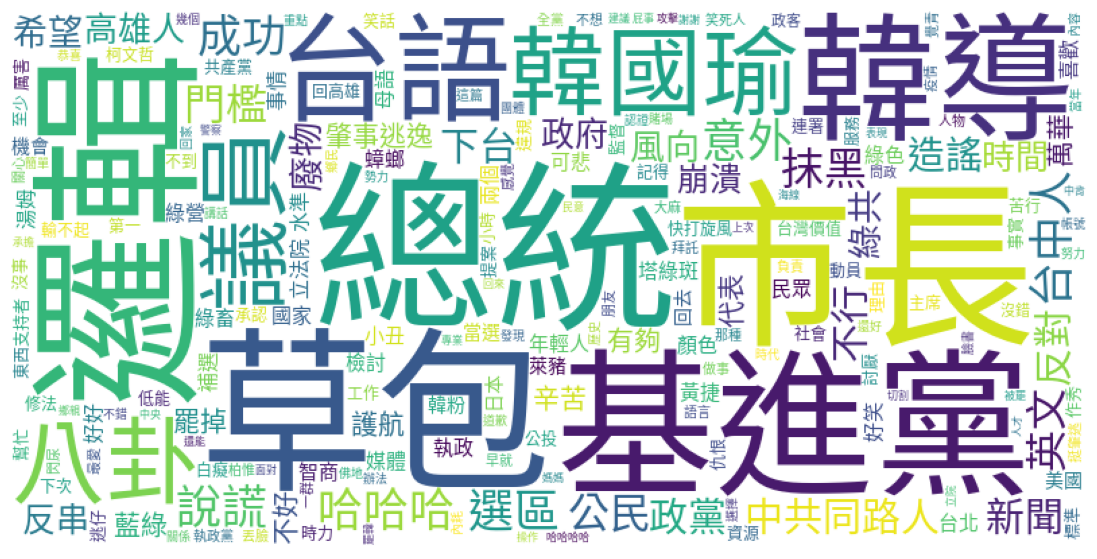

In [496]:
dict_gossip = Wc_dict(word_count,'Gossiping',2000,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_gossip)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 政黑版文字雲

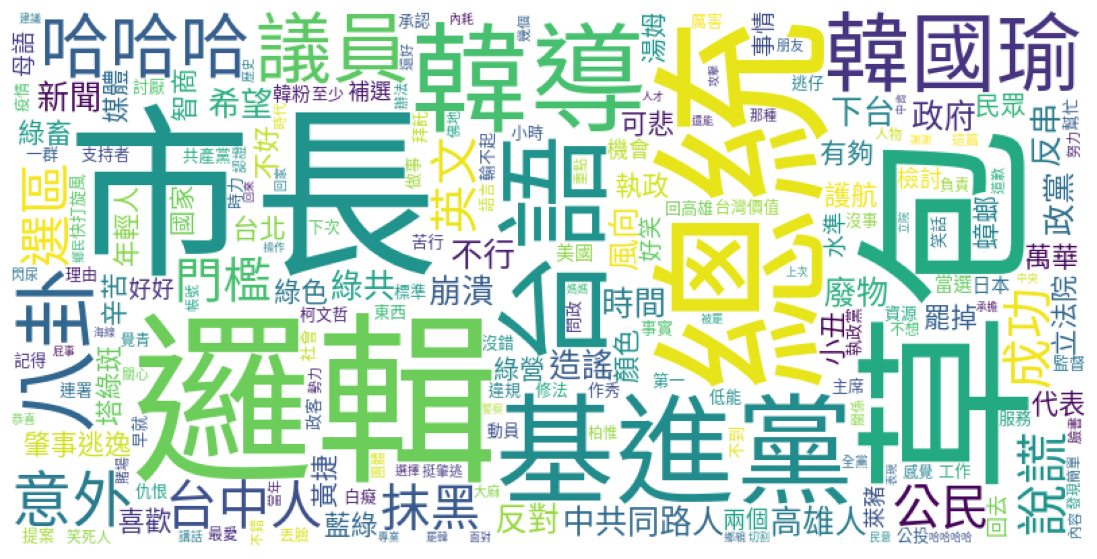

In [498]:
dict_hatepolitics = Wc_dict(word_count,'HatePolitics',2000,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_gossip)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

# DCARD 文章與留言文字雲

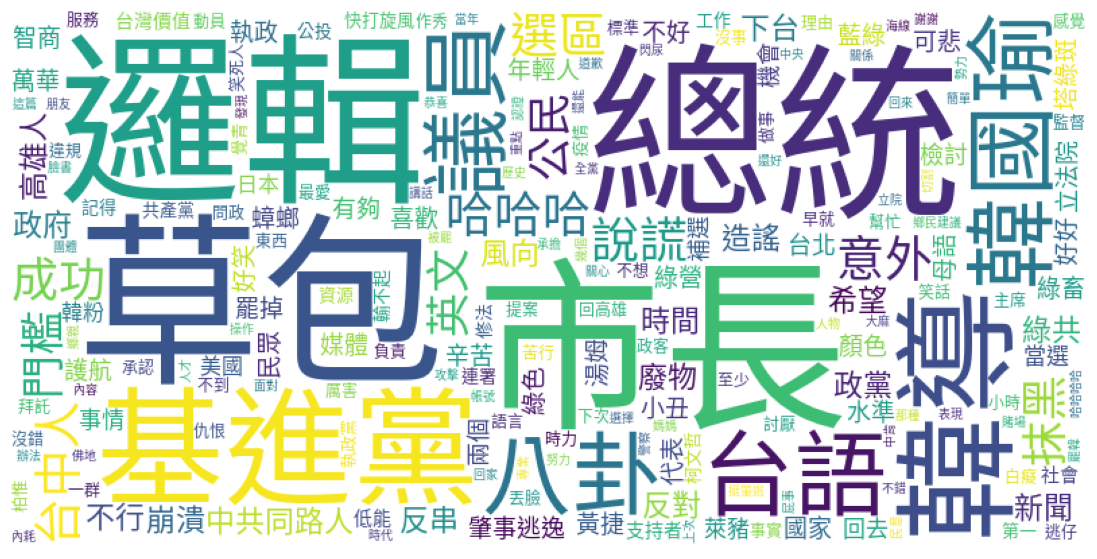

In [499]:
dict_dcard = Wc_dict(word_count,'Dcard',1000,50)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_gossip)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

## **5.議題討論**

* PTT 
1. 議題情緒分析
2. 找出網軍的存在
* Dcard
1. 議題情緒分析
2. 找出網軍的存在

## PTT

In [500]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/bowei_dict.txt')
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
w=['高雄','不用','當初','嘻嘻','反正','一堆','只能','明明','有沒有','只會','整天','一點','幹嘛','這是','有人','地方','還在','台中','投票','選民']
for i in w:
    stopWords.append(i)

Building prefix dict from C:\Users\Roger\Desktop\研究所\碩二上\社群媒體分析\期中專案\dict\dict.txt.big ...
Loading model from cache C:\Users\Roger\AppData\Local\Temp\jieba.ub71048b8c07f5daab26a6e4a18fdb850.cache
Loading model cost 1.105 seconds.
Prefix dict has been built successfully.


In [501]:
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [197]:
bowei_bigram_ptt = MetaData.copy()
bowei_bigram_ptt["word"] = bowei_bigram_ptt.sentence.apply(bigram_getToken_dict)
bowei_bigram_ptt_token = bowei_bigram_ptt.explode('word')

In [198]:
d = {k:v for k,v in bigramfdist.most_common(50)}
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.03 for w in  G.edges(data=True)]

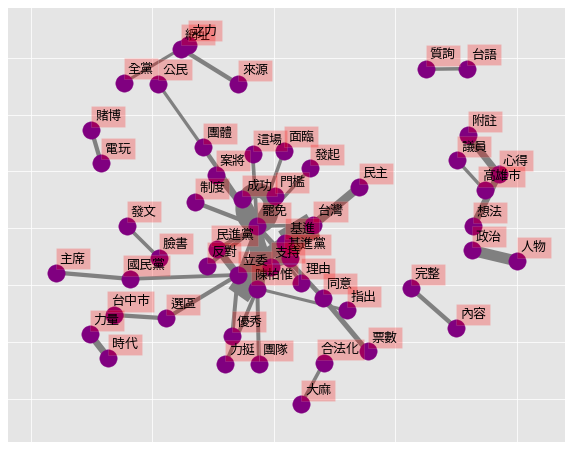

In [199]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

從共線圖可以發現有幾個主要討論的議題，分別是大麻合法化、質詢、賭博電玩等等
下面分析將從這裡發現的議題及新聞上常提到的議題進行分析。

### 根據議題使用liwc情緒分析

### Case1 質詢&出席

In [514]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/liwc/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)
df_liwc

,word,sentiments
0,一無所有,negative
1,七竅生煙,negative
2,上當,negative
3,下流,negative
4,下等,negative
...,...,...
1706,魅力,positive
1707,鮮明,positive
1708,鮮美,positive
1709,鼓勵,positive


In [515]:
keywords1 = ['質詢','出席率']
toMatch = '|'.join(keywords1)
MetaData_issue1=MetaData_token.loc[MetaData['artTitle'].str.contains(toMatch),:]
MetaData_issue1.reset_index(inplace=True, drop=True) 
Reviews_issue1 = MetaData_issue1.iloc[:,0:-1].merge(Reviews_token.loc[:,["artUrl","cmtContent",'word']], how = "left", on = 'artUrl')
data_issue1 = pd.concat([MetaData_issue1.loc[:,["artCat",'artDate',"artUrl","word"]],Reviews_issue1.loc[:,["artCat",'artDate',"artUrl","word"]]],axis=0)

In [516]:
issue1_liwc = pd.merge(data_issue1, df_liwc, on=['word'],how='left')
sentiment_issue1 = issue1_liwc.groupby(['artCat','artDate','sentiments'],as_index=False).size()

<Figure size 1200x800 with 0 Axes>

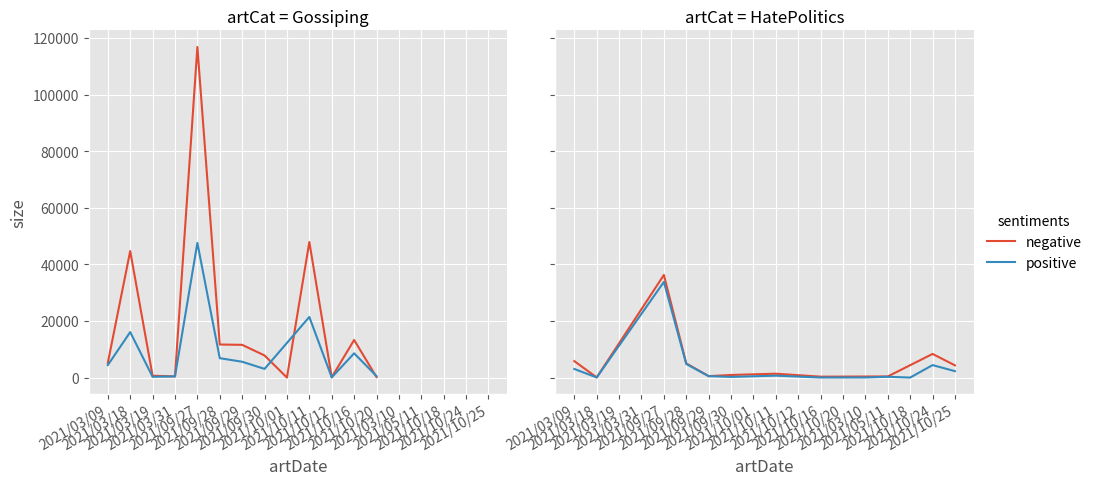

In [517]:
plt.figure(figsize = (12,8))
ax=sns.relplot(x="artDate",y='size',data=sentiment_issue1,hue='sentiments',ci=None,col='artCat',kind='line')
ax.fig.autofmt_xdate() 

可以發現在質詢與出席率這個議題上政黑板的正負面情緒是差不多的但是在八卦版就有明顯的在高峰期負面情緒比較多的情況

### Case2 肇事逃逸

In [520]:
keywords2 = ['肇逃','肇事逃逸']
toMatch = '|'.join(keywords2)
MetaData_issue2=MetaData_token.loc[MetaData['artTitle'].str.contains(toMatch),:]
MetaData_issue2.reset_index(inplace=True, drop=True) 
Reviews_issue2 = MetaData_issue2.iloc[:,0:-1].merge(Reviews_token.loc[:,["artUrl","cmtContent",'word']], how = "left", on = 'artUrl')
data_issue2 = pd.concat([MetaData_issue2.loc[:,["artCat",'artDate',"artUrl","word"]],Reviews_issue2.loc[:,["artCat",'artDate',"artUrl","word"]]],axis=0)

In [519]:
issue2_liwc = pd.merge(data_issue2, df_liwc, on=['word'],how='left')
sentiment_issue2 = issue2_liwc.groupby(['artCat','artDate','sentiments'],as_index=False).size()

<Figure size 1200x800 with 0 Axes>

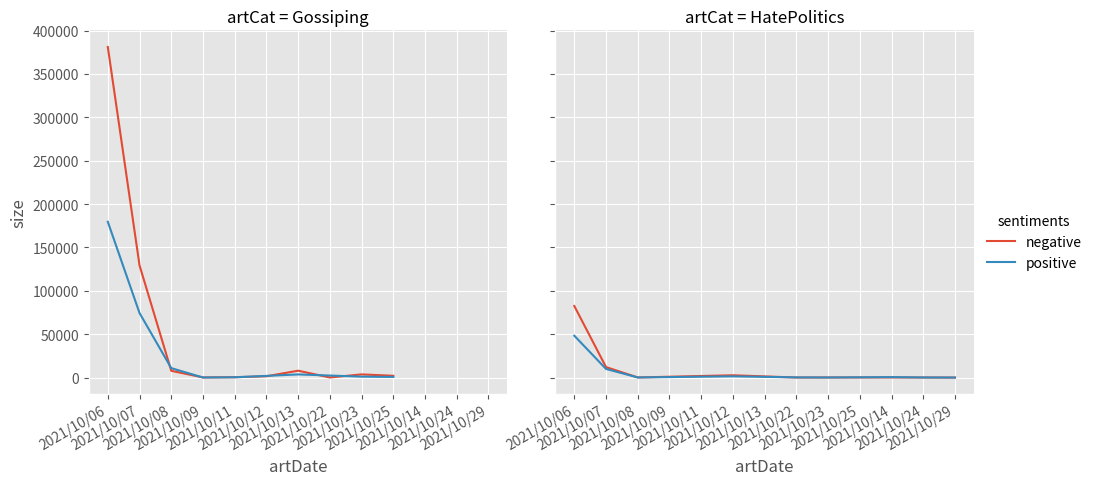

In [521]:
plt.figure(figsize = (12,8))
ax=sns.relplot(x="artDate",y='size',data=sentiment_issue2,hue='sentiments',ci=None,col='artCat',kind='line')
ax.fig.autofmt_xdate() 

在肇事逃逸這個議題上顯然大家沒有太多的興趣，在議題剛爆發的第一天負面情緒很高後來就沒有討論的聲量了。

### Case3 賭博

In [528]:
keywords3 = ['賭博','電動','快打旋風']
toMatch = '|'.join(keywords3)
MetaData_issue3=MetaData_token.loc[MetaData['artTitle'].str.contains(toMatch),:]
MetaData_issue3.reset_index(inplace=True, drop=True) 
Reviews_issue3 = MetaData_issue3.iloc[:,0:-1].merge(Reviews_token.loc[:,["artUrl","cmtContent",'word']], how = "left", on = 'artUrl')
data_issue3 = pd.concat([MetaData_issue3.loc[:,["artCat",'artDate',"artUrl","word"]],Reviews_issue3.loc[:,["artCat",'artDate',"artUrl","word"]]],axis=0)

In [529]:
issue3_liwc = pd.merge(data_issue3, df_liwc, on=['word'],how='left')
sentiment_issue3 = issue3_liwc.groupby(['artCat','artDate','sentiments'],as_index=False).size()

<Figure size 1200x800 with 0 Axes>

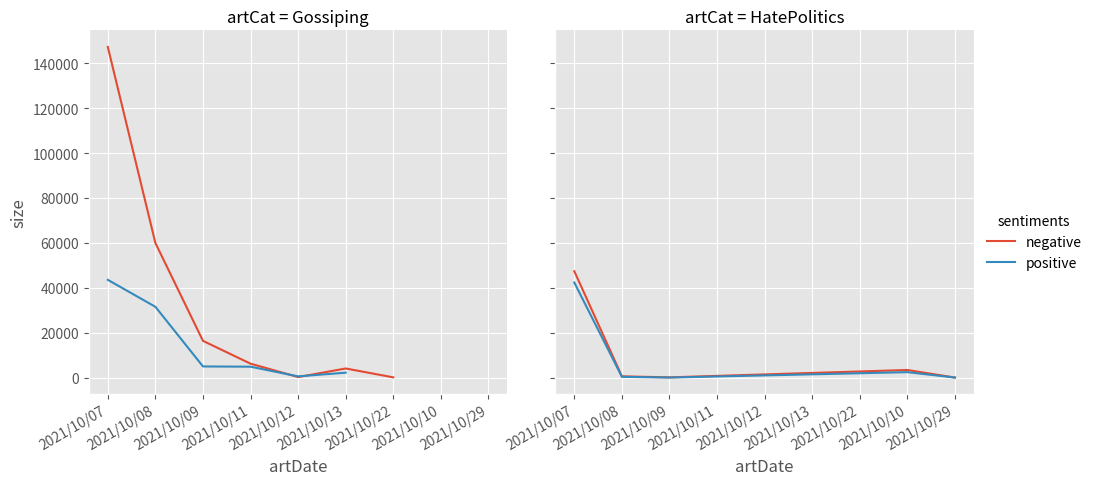

In [530]:
plt.figure(figsize = (12,8))
ax=sns.relplot(x="artDate",y='size',data=sentiment_issue3,hue='sentiments',ci=None,col='artCat',kind='line')
ax.fig.autofmt_xdate() 

賭博這個議題的情況與肇事逃逸情況相似都是在剛出來時負面情緒較高而後面就沒有討論聲量。

可以注意的是在政黑板對於賭博與電玩這個議題的正負面情緒差距並沒有到很大。

### Case4 惡意罷免

In [531]:
keywords4 = ['惡意罷免','報復性']
toMatch = '|'.join(keywords4)
MetaData_issue4=MetaData_token.loc[MetaData['artTitle'].str.contains(toMatch),:]
MetaData_issue4.reset_index(inplace=True, drop=True) 
Reviews_issue4 = MetaData_issue4.iloc[:,0:-1].merge(Reviews_token.loc[:,["artUrl","cmtContent",'word']], how = "left", on = 'artUrl')
data_issue4 = pd.concat([MetaData_issue4.loc[:,["artCat",'artDate',"artUrl","word"]],Reviews_issue4.loc[:,["artCat",'artDate',"artUrl","word"]]],axis=0)

In [532]:
issue4_liwc = pd.merge(data_issue4, df_liwc, on=['word'],how='left')
sentiment_issue4 = issue4_liwc.groupby(['artCat','artDate','sentiments'],as_index=False).size()

<Figure size 1200x800 with 0 Axes>

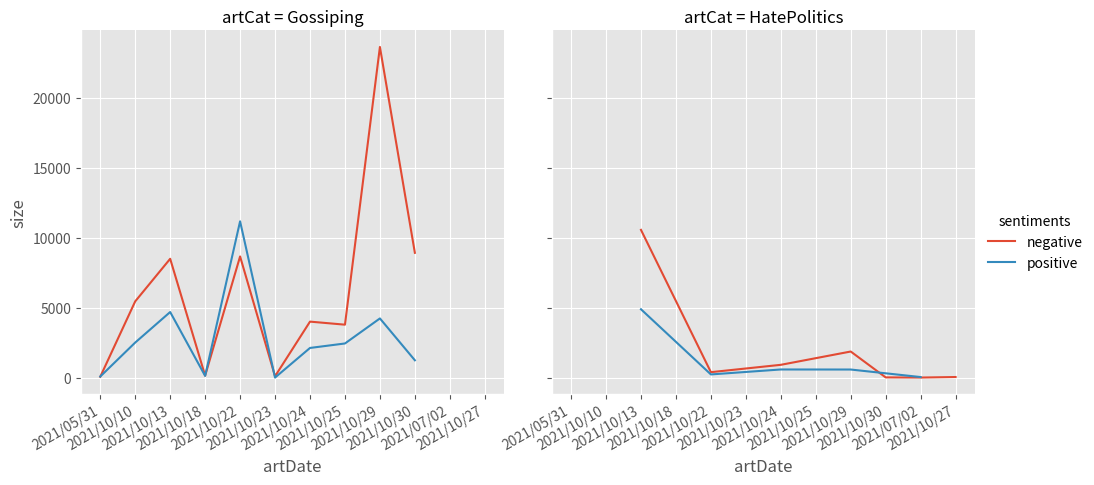

In [533]:
plt.figure(figsize = (12,8))
ax=sns.relplot(x="artDate",y='size',data=sentiment_issue4,hue='sentiments',ci=None,col='artCat',kind='line')
ax.fig.autofmt_xdate() 

惡意罷免的這個議題看起來在八卦版比較有討論熱度，並且可以看到在罷免前正面情緒還是比較大的，而在罷免當週負面情緒大幅超車。

### Case5 中國操作:對話題操作厭惡

In [534]:
keywords5 = ['中國','中共']
toMatch = '|'.join(keywords5)
MetaData_issue5=MetaData_token.loc[MetaData['artTitle'].str.contains(toMatch),:]
MetaData_issue5.reset_index(inplace=True, drop=True) 
Reviews_issue5 = MetaData_issue5.iloc[:,0:-1].merge(Reviews_token.loc[:,["artUrl","cmtContent",'word']], how = "left", on = 'artUrl')
data_issue5 = pd.concat([MetaData_issue5.loc[:,["artCat",'artDate',"artUrl","word"]],Reviews_issue5.loc[:,["artCat",'artDate',"artUrl","word"]]],axis=0)

,artCat,artDate,artUrl,word
0,Gossiping,2021/03/14,https://www.ptt.cc/bbs/Gossiping/M.1615695401....,陳柏惟
1,Gossiping,2021/03/14,https://www.ptt.cc/bbs/Gossiping/M.1615695401....,得罪
2,Gossiping,2021/03/14,https://www.ptt.cc/bbs/Gossiping/M.1615695401....,中共
3,Gossiping,2021/03/14,https://www.ptt.cc/bbs/Gossiping/M.1615695401....,欺負
4,Gossiping,2021/03/14,https://www.ptt.cc/bbs/Gossiping/M.1615695401....,台灣


In [535]:
issue5_liwc = pd.merge(data_issue5, df_liwc, on=['word'],how='left')
sentiment_issue5 = issue5_liwc.groupby(['artCat','artDate','sentiments'],as_index=False).size()

<Figure size 1200x800 with 0 Axes>

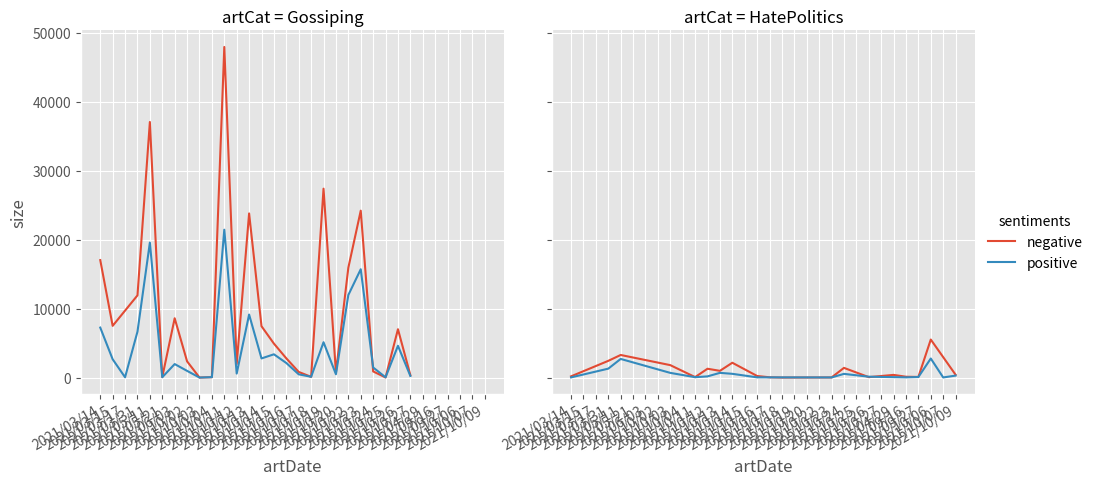

In [536]:
plt.figure(figsize = (12,8))
ax=sns.relplot(x="artDate",y='size',data=sentiment_issue5,hue='sentiments',ci=None,col='artCat',kind='line')
ax.fig.autofmt_xdate() 

在中國這個議題上八卦版一直存在著討論熱度但負面情緒一直是勝過正面情緒，細看留言發現大家對於這個議題操作感到厭倦。

而在政黑版可以看到在罷免前幾週有一波比較大的討論聲量同樣也是負面情緒大於正面情緒。

### Case6 大麻合法化

In [537]:
keywords6 = ['大麻','大麻合法']
toMatch = '|'.join(keywords6)
MetaData_issue6=MetaData_token.loc[MetaData['artTitle'].str.contains(toMatch),:]
MetaData_issue6.reset_index(inplace=True, drop=True) 
Reviews_issue6 = MetaData_issue6.iloc[:,0:-1].merge(Reviews_token.loc[:,["artUrl","cmtContent",'word']], how = "left", on = 'artUrl')
data_issue6 = pd.concat([MetaData_issue6.loc[:,["artCat",'artDate',"artUrl","word"]],Reviews_issue6.loc[:,["artCat",'artDate',"artUrl","word"]]],axis=0)

In [538]:
issue6_liwc = pd.merge(data_issue6, df_liwc, on=['word'],how='left')
sentiment_issue6 = issue6_liwc.groupby(['artCat','artDate','sentiments'],as_index=False).size()

<Figure size 1200x800 with 0 Axes>

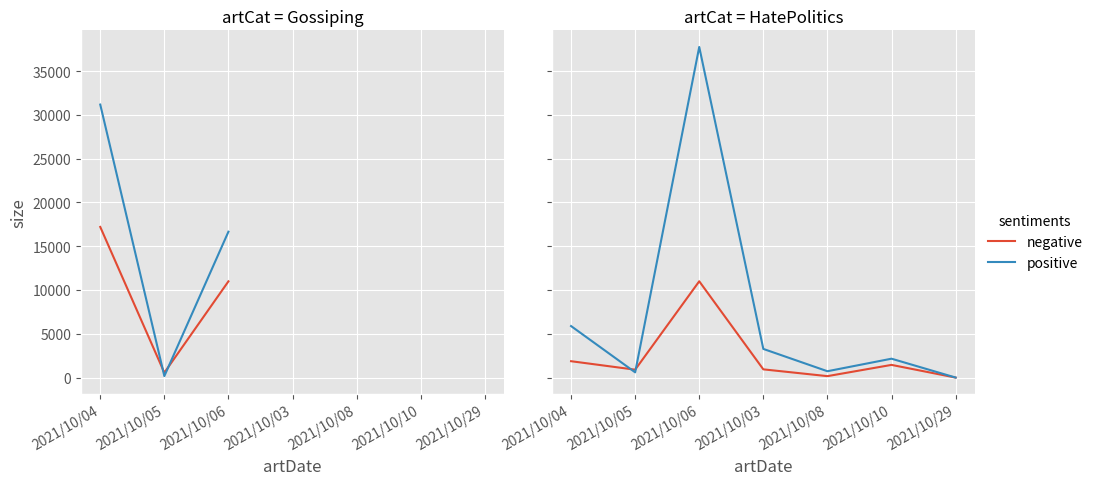

In [539]:
plt.figure(figsize = (12,8))
ax=sns.relplot(x="artDate",y='size',data=sentiment_issue6,hue='sentiments',ci=None,col='artCat',kind='line')
ax.fig.autofmt_xdate() 

大麻合法化這個議題相較前幾個議題不同的是八卦跟政黑的正面情緒都比負面情緒高，顯然大家對於階段性開放大麻持較正面的態度。

各議題聲量比較

In [540]:
a1=issue1_liwc.groupby(['artCat','sentiments'],as_index=False).size()
a1['issue']='質詢'
a2=issue1_liwc.groupby(['artCat','sentiments'],as_index=False).size()
a2['issue']='肇逃'
a3=issue3_liwc.groupby(['artCat','sentiments'],as_index=False).size()
a3['issue']='賭博'
a4=issue4_liwc.groupby(['artCat','sentiments'],as_index=False).size()
a4['issue']='惡意罷免'
a5=issue5_liwc.groupby(['artCat','sentiments'],as_index=False).size()
a5['issue']='中共'
a6=issue6_liwc.groupby(['artCat','sentiments'],as_index=False).size()
a6['issue']='大麻合法化'
data_issue=pd.concat([a1,a2,a3,a4,a5,a6],axis=0)

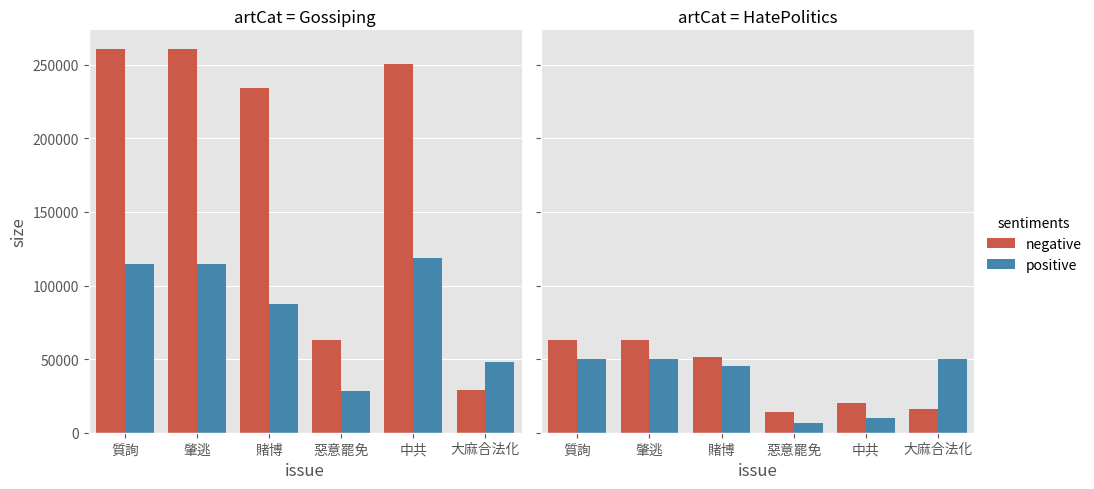

In [541]:
sns.catplot(x='issue',y='size',data=data_issue,hue='sentiments',ci=None,col='artCat',kind='bar')

從討論聲量來看八卦版的討論熱度會大於政黑板，在各議題來看基本上都是負面情緒大於正面情緒（除了大麻合法化），而各議題在八卦版的負面情緒甚至是正面情緒的兩倍以上。

### 抓出特定發文者與推文者用snownlp做情緒分析

In [542]:
Reviews_poster=pd.concat([Reviews_gossip,Reviews_hatepolitic],axis=0).reset_index() 
Reviews_poster.head(5)

,index,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtPoster,cmtContent
0,0,Re:[新聞]【刪Q危機】綠營內部民調揭陳柏惟仇恨值,2021/03/05,06:23:04,https://www.ptt.cc/bbs/Gossiping/M.1614925386....,XXXXGAY,Gossiping,5,4,0,r13974682,:滾動
1,1,Re:[新聞]【刪Q危機】綠營內部民調揭陳柏惟仇恨值,2021/03/05,06:23:04,https://www.ptt.cc/bbs/Gossiping/M.1614925386....,XXXXGAY,Gossiping,5,4,0,userpeter,:
2,2,Re:[新聞]【刪Q危機】綠營內部民調揭陳柏惟仇恨值,2021/03/05,06:23:04,https://www.ptt.cc/bbs/Gossiping/M.1614925386....,XXXXGAY,Gossiping,5,4,0,RRADA,:是網路紅人數位董卓
3,3,Re:[新聞]【刪Q危機】綠營內部民調揭陳柏惟仇恨值,2021/03/05,06:23:04,https://www.ptt.cc/bbs/Gossiping/M.1614925386....,XXXXGAY,Gossiping,5,4,0,BIA,:笑死3f
4,4,Re:[新聞]【刪Q危機】綠營內部民調揭陳柏惟仇恨值,2021/03/05,06:23:04,https://www.ptt.cc/bbs/Gossiping/M.1614925386....,XXXXGAY,Gossiping,5,4,0,koreawargod,:XD


頻繁回文者

In [544]:
poster_review_count=Reviews_poster.groupby(['cmtPoster'],as_index=False).size()
poster_review_count.sort_values('size', ascending = False).head(5)

,cmtPoster,size
16506,kterry01,1292
4801,WTF55665566,1123
2946,MVPGGYY,1062
9229,coffee112,1045
7572,bighorse0,866


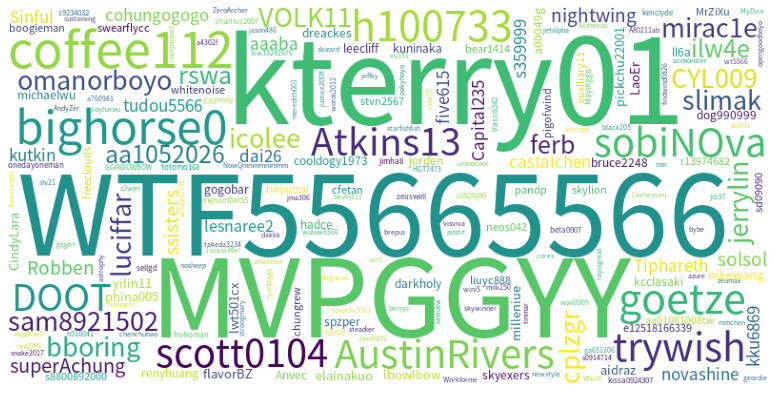

In [128]:
wc_dict = dict(zip(poster_review_count['cmtPoster'],poster_review_count['size'])) #建立成dictionary
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(wc_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

以上列出的id為頻繁回文者

正負面網軍

In [ ]:
def get_sentiment(sent):
    s = SnowNLP(sent)
    return s.sentiments

# 幫每句話加上情緒分數
Reviews_poster['sentimentvalue'] = Reviews_poster.apply(lambda row : get_sentiment(str(row['cmtContent']),), axis = 1)

In [ ]:
boxplot = Reviews_poster.boxplot(column=['sentimentvalue'], showfliers=False)
boxplot

將每個人在每篇文章的留言用snowNLP取情緒分數並且做平均，大於0.7即視為該人在該篇文章為正面情緒，小於0.3即視為該人在該篇文章為負面情緒。

然後統計每個人的正面文章數及負面文章數取差值，隨後將此差值利用三倍標準差法取出outlier，即得到負面網軍及正面網軍。

In [ ]:
sentiment_poster = Reviews_poster.groupby(['artUrl','cmtPoster'])['sentimentvalue'].mean().reset_index()
sentiment=[]
for i in sentiment_poster.sentimentvalue:
    if i > 0.7 :
        sentiment.append('positive')
    elif i < 0.3 :
        sentiment.append('negative')
    else :
        sentiment.append('neutral')
sentiment_poster=pd.concat([sentiment_poster.iloc[:,0:2],pd.DataFrame({'sentiment':sentiment})],axis=1)
sentiment_poster_df=sentiment_poster.groupby(['cmtPoster','sentiment']).count().reset_index()
sentiment_poster_df=sentiment_poster_df.pivot_table(index='cmtPoster', columns='sentiment', values='artUrl', fill_value=0).reset_index()
sentiment_poster_df['cal']=sentiment_poster_df['positive']-sentiment_poster_df['negative']
sentiment_poster_df=sentiment_poster_df.drop(['negative','neutral','positive'],axis=1)

In [ ]:
outlier_ll = sentiment_poster_df.cal.mean() - 3* sentiment_poster_df.cal.std() 
outlier_ul = sentiment_poster_df.cal.mean() + 3* sentiment_poster_df.cal.std()
outlier=sentiment_poster_df.loc[(sentiment_poster_df['cal']> outlier_ul)|(sentiment_poster_df['cal']< outlier_ll),:].reset_index()
outlier_neg=outlier.loc[outlier['cal']<0,:]
outlier_pos=outlier.loc[outlier['cal']>0,:]


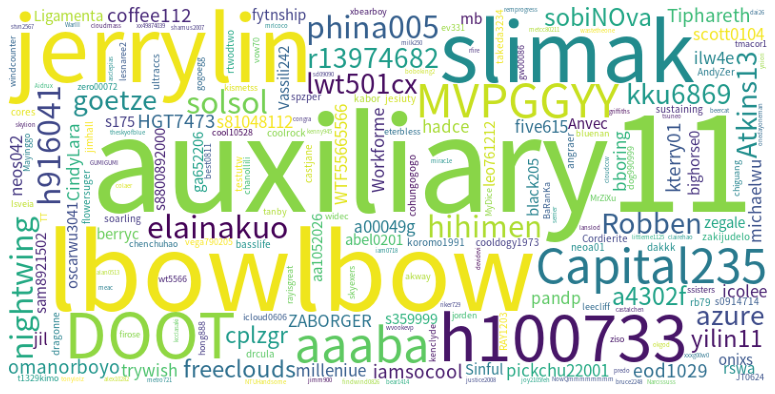

In [130]:
wc_dict = dict(zip(outlier_neg['cmtPoster'], outlier_neg['cal']*-1)) #建立成dictionary
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(wc_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

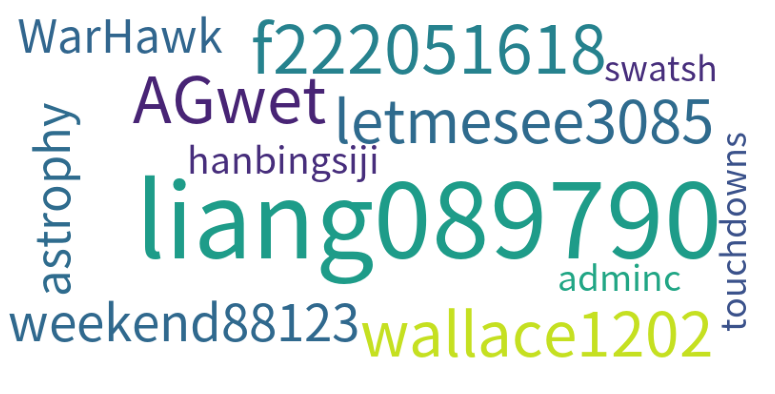

In [131]:
wc_dict = dict(zip(outlier_pos['cmtPoster'], outlier_pos['cal'])) #建立成dictionary
font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(wc_dict)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

可以發現到說正面網軍與負面網軍都不是在頻繁回文文字雲內看到的id,雖然不能確定是否為真正的網軍，但能確定這些人雖然沒有頻繁回文，但幾乎都是回負面/正面情緒的推文。

### Dcard

In [200]:
bigramfdist = FreqDist()
def bigram_getToken_dict(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]
    bigramfdist.update(ngrams(seg_list, 2))
    seg_list2 = ngrams(seg_list, 2)
    seg_list = [" ".join(w) for w in list(seg_list2)]
    return seg_list

In [212]:
bowei_bigram_dcard = Dcard_content_data.copy()
bowei_bigram_dcard["word"] = bowei_bigram_dcard.content.apply(bigram_getToken_dict)
bowei_bigram_dcard_token = bowei_bigram_dcard.explode('word')

In [202]:
d = {k:v for k,v in bigramfdist.most_common(30)}
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v)
    
# 取得edge權重
weights = [w[2]['weight']*0.03 for w in  G.edges(data=True)]

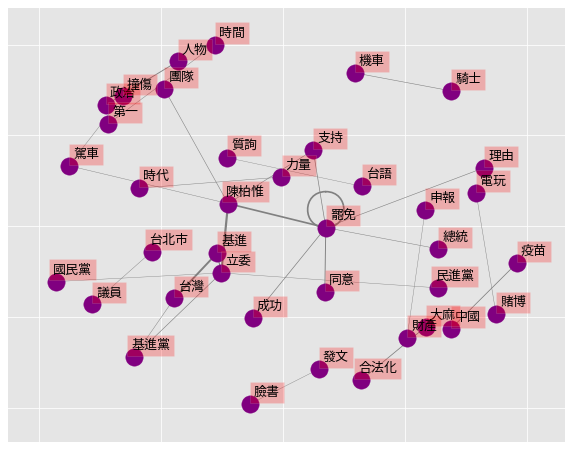

In [203]:
fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 根據議題使用liwc情緒分析

### case 1  肇事逃逸

In [404]:
keywords1 = ['肇事','逃逸','肇逃','肇事逃逸']
toMatch = '|'.join(keywords1)
Content_issue1=Dcard_content_token.loc[Dcard_content_token['title'].str.contains(toMatch),:]
mask = Dcard_reply_token['id'].isin(Content_issue1['id'].values)
reply_issue1=Dcard_reply_token[mask]
data_issue1 = pd.concat([Content_issue1.loc[:,["id","date","word"]],reply_issue1.loc[:,["id","date","word"]]],axis=0)

,id,date,word
44,237290497.0,20211023,腦子
44,237290497.0,20211023,台中人
44,237290497.0,20211023,終於
44,237290497.0,20211023,趕走
44,237290497.0,20211023,民主


In [405]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data_issue1, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['date','sentiments'],as_index=False).size()
sentiment_count['date'] = pd.to_datetime(sentiment_count['date'],format='%Y%m%d')

,date,sentiments,size
0,2021-10-06,negative,175
1,2021-10-06,positive,100
2,2021-10-07,negative,13
3,2021-10-07,positive,8
4,2021-10-08,negative,2
5,2021-10-18,negative,6
6,2021-10-18,positive,1
7,2021-10-23,negative,1
8,2021-10-23,positive,1


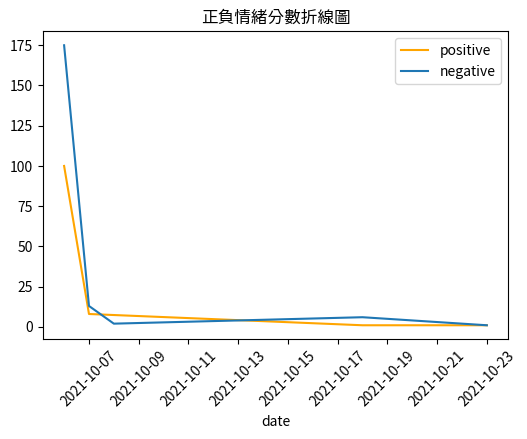

In [406]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號
plt.title('正負情緒分數折線圖')
plt.plot(p['date'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['date'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('date')
plt.show()

10月06日資深媒體人爆料陳柏惟過往曾肇事逃逸，此消息一出立即引起大家討論，在Dcard版上更是出現大量的負面情緒，不過這波熱度沒有延續，往後文章沒有出現明顯情緒


### Case 2 賭博-電玩快打旋風

In [219]:
keywords2 = ['賭博','電玩','電動','快打旋風']
toMatch = '|'.join(keywords2)
Content_issue2=Dcard_content_token.loc[Dcard_content_token['title'].str.contains(toMatch),:]
mask = Dcard_reply_token['id'].isin(Content_issue2['id'].values)
reply_issue2=Dcard_reply_token[mask]
data_issue2 = pd.concat([Content_issue2.loc[:,["id","date","word"]],reply_issue2.loc[:,["id","date","word"]]],axis=0)

,id,date,word
187,237176652.0,20211008,塔綠班
187,237176652.0,20211008,勇於
187,237176652.0,20211008,承擔
191,237176002.0,20211007,基進
191,237176002.0,20211007,立委


In [412]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data_issue2, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['date','sentiments'],as_index=False).size()
sentiment_count['date'] = pd.to_datetime(sentiment_count['date'],format='%Y%m%d')

,date,sentiments,size
0,2021-10-07,negative,13
1,2021-10-07,positive,14
2,2021-10-08,negative,13
3,2021-10-08,positive,6


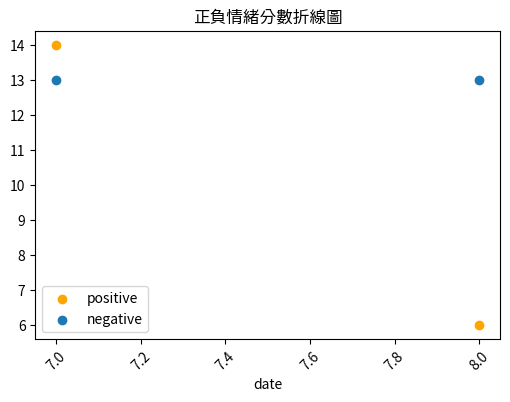

In [428]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號
plt.title('正負情緒分數折線圖')
plt.scatter(p['date'].dt.day.tolist(), p['size'].values, label='positive',color="orange")
plt.scatter(n['date'].dt.day.tolist(), n['size'].values, label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
plt.xlabel('date')
plt.show()

陳柏惟曾捲入賭博電玩案，不過此事件在陳柏惟立即跳出澄清後，即沒有討論的聲量

### Case3 惡意罷免


In [222]:
keywords3 = ['惡意罷免','報復','報復性']
toMatch = '|'.join(keywords3)
Content_issue3=Dcard_content_token.loc[Dcard_content_token['title'].str.contains(toMatch),:]
mask = Dcard_reply_token['id'].isin(Content_issue3['id'].values)
reply_issue3=Dcard_reply_token[mask]
data_issue3 = pd.concat([Content_issue3.loc[:,["id","date","word"]],reply_issue3.loc[:,["id","date","word"]]],axis=0)

,id,date,word
36,237291358.0,20211023,罷免
36,237291358.0,20211023,報復
36,237291358.0,20211023,得爛
36,237291358.0,20211023,嘴巴
36,237291358.0,20211023,愛台灣


In [223]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data_issue3, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['date','sentiments'],as_index=False).size()
sentiment_count['date'] = pd.to_datetime(sentiment_count['date'],format='%Y%m%d')

,date,sentiments,size
0,2021-10-13,negative,10
1,2021-10-13,positive,6
2,2021-10-14,negative,2
3,2021-10-14,positive,4
4,2021-10-23,negative,9
5,2021-10-23,positive,1
6,2021-10-25,positive,3


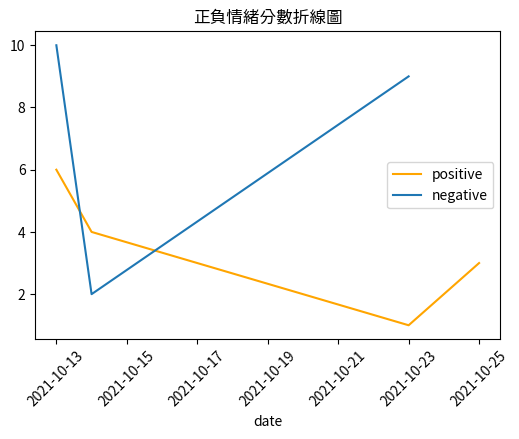

In [224]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號
plt.title('正負情緒分數折線圖')
plt.plot(p['date'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['date'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('date')
plt.show()

罷免陳柏惟一案有許多人認為是報復性罷免，由上圖可以看出，罷免前兩周也開始有人在討論此議題，且多為負面情緒

### Case4 財產申報

In [225]:
keywords4 = ['財產','申報','不實']
toMatch = '|'.join(keywords4)
Content_issue4=Dcard_content_token.loc[Dcard_content_token['title'].str.contains(toMatch),:]
mask = Dcard_reply_token['id'].isin(Content_issue4['id'].values)
reply_issue4=Dcard_reply_token[mask]
data_issue4 = pd.concat([Content_issue4.loc[:,["id","date","word"]],reply_issue4.loc[:,["id","date","word"]]],axis=0)

,id,date,word
97,237275873.0,20211021,連勝文
97,237275873.0,20211021,顏家
97,237275873.0,20211021,關係
97,237275873.0,20211021,說謊
97,237275873.0,20211021,東扯


In [226]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data_issue4, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['date','sentiments'],as_index=False).size()
sentiment_count['date'] = pd.to_datetime(sentiment_count['date'],format='%Y%m%d')

,date,sentiments,size
0,2021-09-26,negative,25
1,2021-09-26,positive,10
2,2021-09-27,negative,3
3,2021-09-27,positive,3
4,2021-10-08,negative,2
5,2021-10-08,positive,6
6,2021-10-09,negative,2
7,2021-10-14,negative,8
8,2021-10-14,positive,4
9,2021-10-15,negative,3


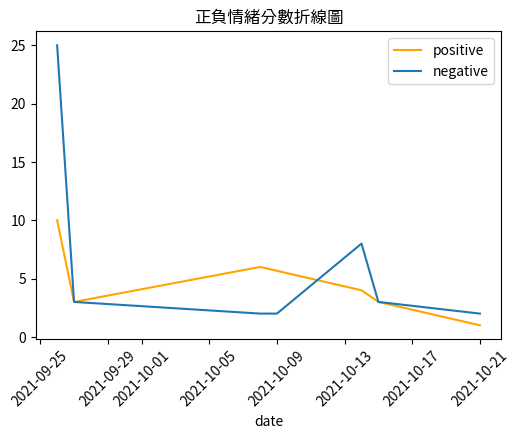

In [227]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號
plt.title('正負情緒分數折線圖')
plt.plot(p['date'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['date'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('date')
plt.show()

陳柏惟遭質疑財務申報不實一事，在Dcard受到特別的討論，不過沒有明顯的情緒方向，正負情緒不斷交錯

### Case5 大麻合法化

In [228]:
keywords5 = ['大麻','合法','合法化']
toMatch = '|'.join(keywords5)
Content_issue5=Dcard_content_token.loc[Dcard_content_token['title'].str.contains(toMatch),:]
mask = Dcard_reply_token['id'].isin(Content_issue5['id'].values)
reply_issue5=Dcard_reply_token[mask]
data_issue5 = pd.concat([Content_issue5.loc[:,["id","date","word"]],reply_issue5.loc[:,["id","date","word"]]],axis=0)

,id,date,word
169,237192124.0,20211010,基進
169,237192124.0,20211010,立委
169,237192124.0,20211010,陳柏惟
169,237192124.0,20211010,陷入
169,237192124.0,20211010,肇逃


In [229]:
#文章和與LIWC情緒字典做合併
data_liwc = pd.merge(data_issue5, df_liwc, on=['word'],how='left')

#算出每天情緒總和(sentiment_count)
sentiment_count = data_liwc.groupby(['date','sentiments'],as_index=False).size()
sentiment_count['date'] = pd.to_datetime(sentiment_count['date'],format='%Y%m%d')

,date,sentiments,size
0,2021-10-04,negative,9
1,2021-10-04,positive,16
2,2021-10-10,negative,27
3,2021-10-10,positive,22
4,2021-10-18,negative,3
5,2021-10-18,positive,3


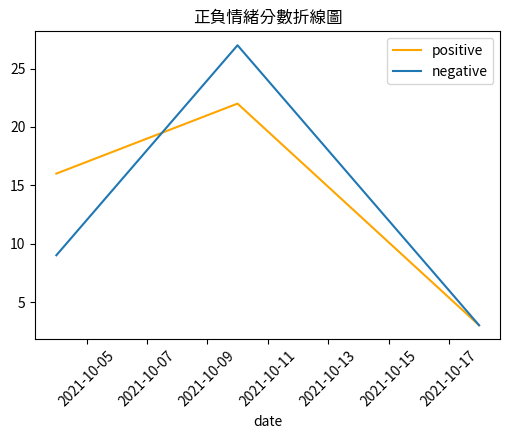

In [230]:
p = sentiment_count[sentiment_count['sentiments']=='positive']
n = sentiment_count[sentiment_count['sentiments']=='negative']

plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Taipei Sans TC Beta'] #使中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #用來正常顯示負號
plt.title('正負情緒分數折線圖')
plt.plot(p['date'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['date'].tolist(), n['size'], label='negative')
plt.xticks(rotation= 45, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('date')
plt.show()

In [ ]:
陳柏惟支持大麻合法化一事，也被拿出來討論，由上圖可以看出負面情緒較多

## 性別

In [232]:
gender_content_count = Dcard_content_data.groupby(["gender"],as_index = False).size()
gender_content_count.sort_values(by=['size'], ascending=False,inplace=True)
gender_content_count.head(10)

,gender,size
1,M,360
0,F,25


In [233]:
gender_reply_count = Dcard_reply_data.groupby(["gender"],as_index = False).size()
gender_reply_count.sort_values(by=['size'], ascending=False,inplace=True)
gender_reply_count.head(10)

,gender,size
2,M,5779
1,F,638
0,D,11


## 學校

統計發文者學校分配

In [348]:
school_content_count = Dcard_content_data.groupby(["school"],as_index = False).size()
school_content_count.sort_values(by=['size'], ascending=False,inplace=True)
school_content_count.head(10)

,school,size
95,臺北醫學大學,30
3,Endless Joy,27
90,淡江大學,23
103,長榮大學,20
35,國立交通大學,16
4,Evans,16
47,國立臺灣大學,15
48,國立臺灣師範大學,10
57,國立高雄科技大學,9
67,奶酒咖啡,7


統計留言者學校分配

In [349]:
school_reply_count = Dcard_reply_data.groupby(["school"],as_index = False).size()
school_reply_count.sort_values(by=['size'], ascending=False,inplace=True)
school_reply_count.head(10)

,school,size
216,國立臺灣大學,480
428,輔仁大學,240
102,中原大學,203
19,Diorama,160
189,國立交通大學,157
209,國立臺北大學,157
331,朝陽科技大學,156
398,臺北醫學大學,149
197,國立成功大學,136
354,淡江大學,124


留言數前十大學校，多數位於北部，可見北部的學生較會於網路上發言，其中又以台灣大學居冠。

而奇怪的是，第四名為Diorama，此名為使用者自行更改卡稱，且單一人就發表160則留言，這行為讓我們懷疑他是網軍，因此我們將更進一步對這類型的帳號進行討論

### 找出網軍(政治立場鮮明者)的存在

In [431]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')
#新增自定義字典
jieba.load_userdict('./dict/cyber_army/user_dict.txt')
with open('./dict/cyber_army/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]
w=['高雄','不用','當初','嘻嘻','反正','一堆','只能','明明','有沒有','只會','整天','一點','幹嘛','這是','有人','地方','還在','台中','投票','選民']
for i in w:
    stopWords.append(i)

Building prefix dict from C:\Users\Roger\Desktop\研究所\碩二上\社群媒體分析\期中專案\dict\dict.txt.big ...
Loading model from cache C:\Users\Roger\AppData\Local\Temp\jieba.ub71048b8c07f5daab26a6e4a18fdb850.cache
Loading model cost 2.475 seconds.
Prefix dict has been built successfully.


In [430]:
filepath = ['negative','positive']
d_liwc = []
for file in filepath:
    filename = f"./dict/cyber_army/{file}.txt"
    with open(filename, 'r', encoding='UTF-8-sig') as f:
        d_liwc.append([f.read().split(","),file])
df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)

,word,sentiments
0,一無所有,negative
1,七竅生煙,negative
2,上當,negative
3,下流,negative
4,下等,negative
...,...,...
1772,魅力,positive
1773,鮮明,positive
1774,鮮美,positive
1775,鼓勵,positive


In [432]:
mask1 = ~school_reply_count.school.str.contains('大學')
mask2 = ~school_reply_count.school.str.contains('學校')
mask3 = school_reply_count['size'] > 15
mask = mask1 & mask2 & mask3

In [433]:
special_people = school_reply_count[mask]['school'].values
special = {'id':special_people,'negative':[],'positive':[],'total_like':[],'reply_count':[]}
anti_bowei = []
pro_bowei = []
Dcard_reply_data['word'] = Dcard_reply_data.content.apply(getToken)
for i in special_people:
    mask = Dcard_reply_data['school'] == i
    Dcard_reply_data[mask].explode('word')['word']
    n_count = sum(Dcard_reply_data[mask].explode('word').merge(df_liwc,on='word',how = 'left')['sentiments'] == 'negative')
    p_count = sum(Dcard_reply_data[mask].explode('word').merge(df_liwc,on='word',how = 'left')['sentiments'] == 'positive')
    special['negative'].append(n_count)
    special['positive'].append(p_count)
    try :
        if n_count/p_count >= 1 :
            anti_bowei.append(i)
        else :
            pro_bowei.append(i)
    except ZeroDivisionError :
        anti_bowei.append(i)

In [434]:
for ident in special['id'] :
    mask = Dcard_reply_data['school'] == ident
    special['total_like'].append(Dcard_reply_data[mask]['likeCount'].sum())
    special['reply_count'].append(len(Dcard_reply_data[mask]['content']))
special_data = pd.DataFrame(special)
special_data['np_ratio'] = round(special_data['negative']/special_data['positive'],2)
special_data['LikePerReply'] = round(special_data['total_like']/special_data['reply_count'],2)
special_data

,id,negative,positive,total_like,reply_count,np_ratio,LikePerReply
0,Diorama,253,112,460.0,160,2.26,2.88
1,Discogood,69,12,510.0,79,5.75,6.46
2,綠的世界,66,14,396.0,52,4.71,7.62
3,我只是喜歡設計,8,7,204.0,38,1.14,5.37
4,BeatDark,9,11,105.0,33,0.82,3.18
5,越會嘴炮官位越高,9,11,371.0,32,0.82,11.59
6,Evans,26,8,359.0,32,3.25,11.22
7,讀書人,21,20,80.0,31,1.05,2.58
8,趙雲謀士賈詡,19,1,193.0,30,19.00,6.43
9,貓貓頭社長,25,8,272.0,29,3.12,9.38


這些使用者中，Diorama發表最多留言，其活躍度非常高；多金巴菲哥獲得最多愛心數，其發言受到許多人喜愛；兔兔留言的負面情緒比例最高，可以觀察其是否為任何事都批評的網軍

### 觀察各學校發言之情緒

In [439]:
mask1 = school_reply_count.school.str.contains('大學')
mask2 = school_reply_count.school.str.contains('學校')
mask3 = school_reply_count['size'] > 1
mask = (mask1 | mask2) & mask3

In [440]:
school = school_reply_count[mask]['school'].values
school_data = {'school':school,'negative':[],'positive':[],'total_like':[],'highest_like':[],'reply_count':[]}
anti_bowei = []
pro_bowei = []
Dcard_reply_data['word'] = Dcard_reply_data.content.apply(getToken)
for i in school:
    mask = Dcard_reply_data['school'] == i
    n_count = sum(Dcard_reply_data[mask].explode('word').merge(df_liwc,on='word',how = 'left')['sentiments'] == 'negative')
    p_count = sum(Dcard_reply_data[mask].explode('word').merge(df_liwc,on='word',how = 'left')['sentiments'] == 'positive')
    school_data['negative'].append(n_count)
    school_data['positive'].append(p_count)
    try :
        if n_count/p_count >= 1 :
            anti_bowei.append(i)
        else :
            pro_bowei.append(i)
    except ZeroDivisionError :
        anti_bowei.append(i)

In [441]:
for ident in school_data['school'] :
    mask = Dcard_reply_data['school'] == ident
    school_data['total_like'].append(Dcard_reply_data[mask]['likeCount'].sum())
    school_data['reply_count'].append(len(Dcard_reply_data[mask]['content']))
    school_data['highest_like'].append(Dcard_reply_data[mask]['likeCount'].max())
school_data = pd.DataFrame(school_data)
school_data['np_ratio'] = round(school_data['negative']/school_data['positive'],2)
school_data['LikePerReply'] = round(school_data['total_like']/school_data['reply_count'],2)
school_data.head(10)

,school,negative,positive,total_like,highest_like,reply_count,np_ratio,LikePerReply
0,國立臺灣大學,188,99,8443.0,1132.0,480,1.90,17.59
1,輔仁大學,122,50,2575.0,124.0,240,2.44,10.73
2,中原大學,115,51,2882.0,151.0,203,2.25,14.20
3,國立交通大學,77,33,4649.0,3089.0,157,2.33,29.61
4,國立臺北大學,65,36,1321.0,180.0,157,1.81,8.41
5,朝陽科技大學,91,58,1488.0,132.0,156,1.57,9.54
6,臺北醫學大學,78,69,517.0,55.0,149,1.13,3.47
7,國立成功大學,76,29,1535.0,285.0,136,2.62,11.29
8,淡江大學,71,36,1683.0,394.0,124,1.97,13.57
9,國立中正大學,52,32,1443.0,289.0,117,1.62,12.33


In [460]:
mask = np.where(school_data['highest_like'] == max(school_data['highest_like']),True,False)
mask2 = np.where(school_data['np_ratio'] == max(school_data['np_ratio']),True,False)

In [459]:
school_data.dropna(how='all',axis=1,inplace = True)
school_data

,school,negative,positive,total_like,highest_like,reply_count,np_ratio,LikePerReply
0,國立臺灣大學,188,99,8443.0,1132.0,480,1.90,17.59
1,輔仁大學,122,50,2575.0,124.0,240,2.44,10.73
2,中原大學,115,51,2882.0,151.0,203,2.25,14.20
3,國立交通大學,77,33,4649.0,3089.0,157,2.33,29.61
4,國立臺北大學,65,36,1321.0,180.0,157,1.81,8.41
...,...,...,...,...,...,...,...,...
130,健行科技大學,0,0,7.0,4.0,2,NaN,3.50
131,國立臺東專科學校,6,2,2.0,1.0,2,3.00,1.00
132,夏威夷大學,0,0,10.0,7.0,2,NaN,5.00
133,多倫多大學,1,0,13.0,8.0,2,NaN,6.50


In [461]:
print("愛心總數最高",school_data[mask][['school','highest_like']])
print("負面比例最高",school_data[mask2][['school','np_ratio']])

愛心總數最高    school  highest_like
3  國立交通大學        3089.0
負面比例最高    school  np_ratio
51   剿蔡大學      43.0


#### 新增反民進黨、反陳柏惟字典

In [25]:
con_words = []
file = './dict/cyber_army/con_bowei.txt'
with open(file, 'r', encoding='UTF-8-sig') as f:
    con_words = f.read().split("\n")
print(con_words[:15])

['塔綠斑', '塔綠班', '塔綠', '塔綠狗', '冥禁黨', '冥進黨', '菜陰魂', '蔡陰魂', '綠狗', '雞雞黨', '蔡皇', '蔡皇帝', '菜皇帝', '菜皇', '蔡禁評']


In [32]:
# 含有con words(特定立場的反對文字)的留言比例高達 10 %
count = 0
for i in range(len(con_words)):
    count += sum(Dcard_reply_data['content'].str.contains(con_words[i]))
print('含有反民進黨、陳柏惟字典之字詞的留言比例為：',round(count/len(Dcard_reply_data['content']),4)*100,'%')

含有反民進黨、陳柏惟字典之字詞的留言比例為： 13.28 %
